# Multi-output Gaussian Processes in PyMC [GSoC Week 10-12]

> A personal note on the progress of incoporating Multi-output Gaussian Processes (MOGPs) into PyMC. Week 10-12 focus on implementing ICM and LCM using Kronecker product.
- toc: true 
- badges: true
- comments: true
- categories: [GP, Gaussian Process, Kronecker product]

**This work is supported by GSoC, NumFOCUS, and PyMC team.**

Given input data $x$ and different outputs $o$, the ICM kernel $K$ is calculated by Kronecker product:

$$
K = K_1(x, x') \otimes K_2(o, o')
$$


NOTE: This Kronecker product can ONLY work with same input data. In addition, The kernels for input data need to be stationary.

In [1]:
import numpy as np
import pymc as pm
from pymc.gp.cov import Covariance
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

### Set up training data: same X, three Y outputs

In [3]:
N = 50
train_x = np.linspace(0, 1, N)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [4]:
train_x.shape, train_y.shape

((50,), (50, 3))

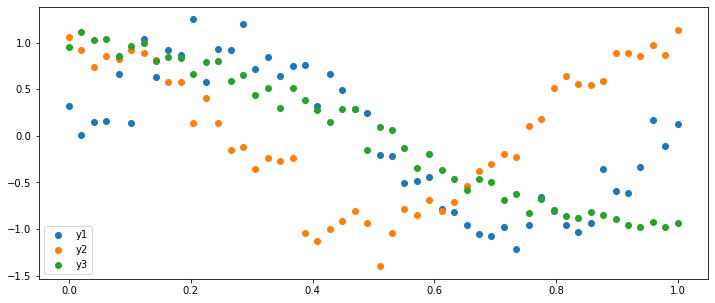

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [6]:
train_x.shape, train_y.shape

((50,), (50, 3))

In [7]:
x = train_x.reshape(-1,1)
y = train_y.reshape(-1,1)
x.shape, y.shape

((50, 1), (150, 1))

In [8]:
task_i = np.linspace(0, 2, 3)[:, None]
Xs = [x, task_i] # For training
Xs[0].shape, Xs[1].shape, x.shape

((50, 1), (3, 1), (50, 1))

In [9]:
M = 100
xnew = np.linspace(-0.5, 1.5, M)
Xnew = pm.math.cartesian(xnew, task_i) # For prediction
Xnew.shape

(300, 2)

### Option 1: Implement ICM (one kernel) by using LatentKron with Coregion kernel

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

#### Create a model

In [44]:
Xs[0].shape, Xs[1]

((50, 1),
 array([[0.],
        [1.],
        [2.]]))

In [ ]:
y = (K + noise) * α = (L x L.T) * α = y
B = L * α
L.T * B = y
B = solve(y, L) = (L\y)
α = solve(B, L.T) = (B\L.T) = L\(L\y)

In [10]:
with pm.Model() as model:
    # Kernel: K_1(x,x')
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
    
    # Coregion B matrix: K_2(o,o')
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)
    
    # Specify the GP.  The default mean function is `Zero`.
    mogp = pm.gp.LatentKron(cov_funcs=[cov, coreg])
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    # Place a GP prior over thXse function f.
    f = mogp.prior("f", Xs=Xs)
    y_ = pm.Normal("y_", mu=f, sigma=sigma, observed=y.squeeze())    

In [11]:
coreg.full(task_i).eval()

array([[ 2.46386292e+01, -1.21279356e+00, -3.43292549e+00],
       [-1.21279356e+00,  3.66420073e+00, -6.43785621e-03],
       [-3.43292549e+00, -6.43785621e-03,  5.78450962e+00]])

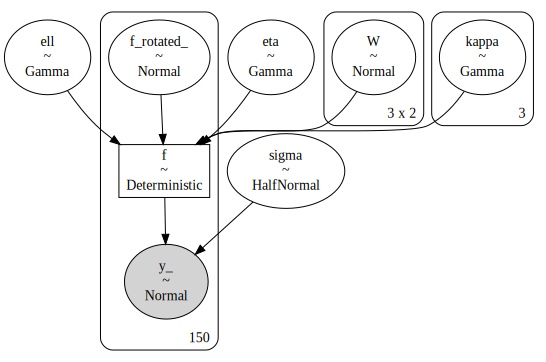

In [12]:
pm.model_to_graphviz(model)

In [13]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma, f_rotated_]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 274 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 11min 14s, sys: 24min 24s, total: 35min 38s
Wall time: 4min 41s


#### Prediction

In [14]:
%%time
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 38.4 s, sys: 39.5 s, total: 1min 17s
Wall time: 11.9 s


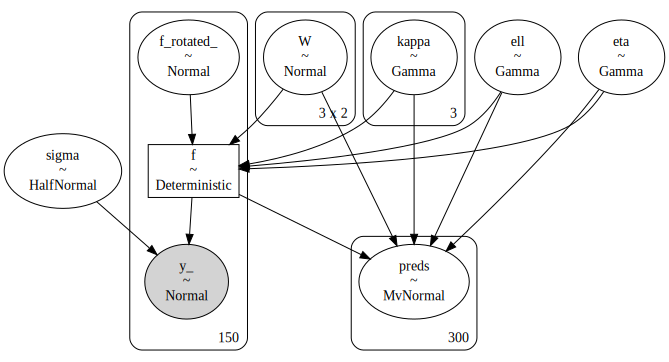

In [15]:
pm.model_to_graphviz(model)

In [16]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 300)

#### Plot the first GP

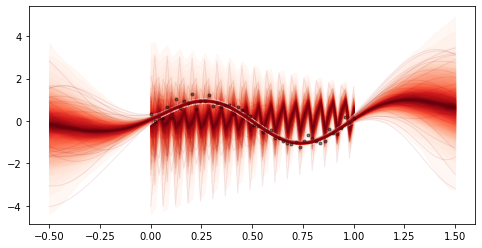

In [18]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,0], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, 0:N], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 0], xnew)
plt.show()

#### Plot the second GP

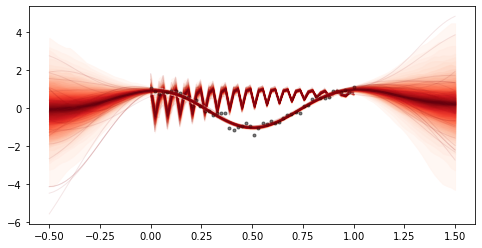

In [20]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(1,1, figsize=(8,4))
plt.plot(x, train_y[:,1], 'ok', ms=3, alpha=0.5, label="Data 1");
plot_gp_dist(axes, f_pred[:, N:2*N], x)
plot_gp_dist(axes, f_pred[:,Xnew[:,1] == 1], xnew)
plt.show()

### Option 2.1: Implement ICM (one kernel) by using pm.gp.cov.Kron with pm.gp.Marginal

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [21]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [22]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [23]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((50, 50), (3, 3), (150, 150))

In [24]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 97 seconds.


CPU times: user 4min 40s, sys: 8min 9s, total: 12min 50s
Wall time: 1min 41s


#### Prediction

In [25]:
%%time
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 37.4 s, sys: 37.2 s, total: 1min 14s
Wall time: 10.7 s


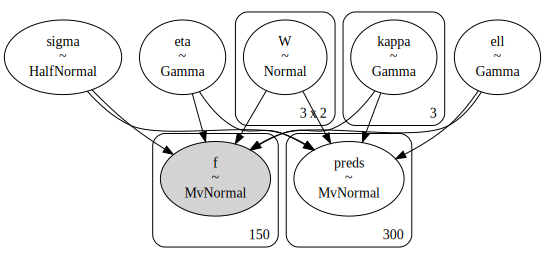

In [26]:
pm.model_to_graphviz(model)

In [27]:
Xnew.shape

(300, 2)

In [28]:
Marginalf_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 300)

#### Plot the GP prediction

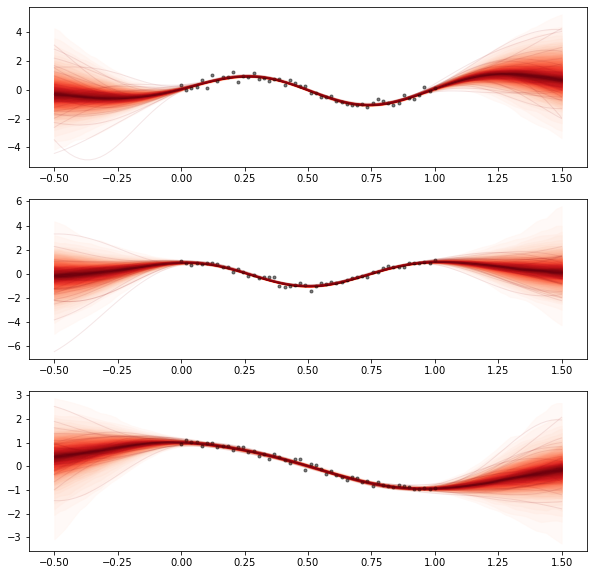

In [29]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [30]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.083,2.060,-3.471,4.098,0.138,0.115,221.0,244.0,NaN
"W[0, 1]",-0.020,2.143,-4.281,3.720,0.120,0.103,320.0,263.0,NaN
"W[1, 0]",0.015,2.243,-4.221,4.062,0.166,0.127,198.0,167.0,NaN
"W[1, 1]",0.063,2.115,-3.989,3.917,0.154,0.109,188.0,253.0,NaN
"W[2, 0]",-0.042,1.194,-2.528,2.206,0.086,0.066,269.0,205.0,NaN
"W[2, 1]",0.108,1.108,-2.004,2.254,0.076,0.060,240.0,162.0,NaN
ell,0.333,0.045,0.255,0.417,0.002,0.002,360.0,281.0,NaN
eta,0.681,0.275,0.264,1.174,0.017,0.012,262.0,295.0,NaN
kappa[0],1.941,1.455,0.082,4.454,0.068,0.048,336.0,168.0,NaN
kappa[1],1.878,1.360,0.043,4.477,0.064,0.046,393.0,216.0,NaN


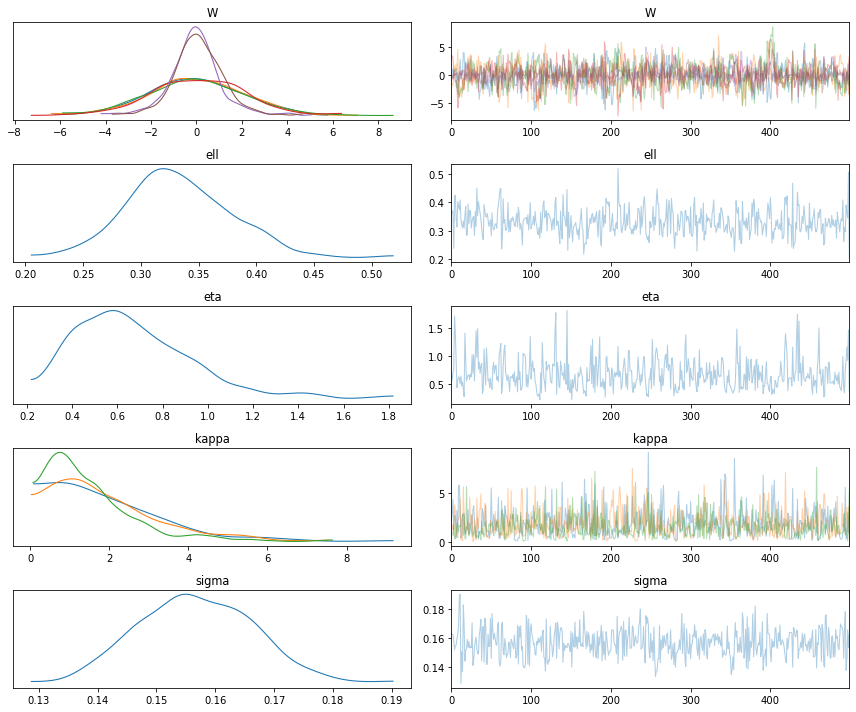

In [31]:
az.plot_trace(gp_trace);
plt.tight_layout()

### Option 2.2: Implement LCM by using pm.gp.cov.Kron with pm.gp.Marginal

$$
K = ( K_{11}(x, x') + K_{12}(x, x') ) \otimes K_2(o, o')
$$

In [32]:
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [33]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    ell2 = pm.Gamma("ell2", alpha=2, beta=0.5)
    eta2 = pm.Gamma("eta2", alpha=3, beta=1)
    cov2 = eta2**2 * pm.gp.cov.Matern32(1, ls=ell2)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    coreg = pm.gp.cov.Coregion(input_dim=1, kappa=kappa, W=W)    
    
    cov_func = pm.gp.cov.Kron([cov+cov2, coreg])    
    sigma = pm.HalfNormal("sigma", sigma=3)    
    gp = pm.gp.Marginal(cov_func=cov_func)    
    y_ = gp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [34]:
cov(x).eval().shape, coreg(task_i).eval().shape, cov_func(X).eval().shape

((50, 50), (3, 3), (150, 150))

In [35]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, ell2, eta2, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 129 seconds.


CPU times: user 6min 3s, sys: 11min 1s, total: 17min 5s
Wall time: 2min 15s


#### Prediction

In [36]:
%%time
with model:
    preds = gp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 45.1 s, sys: 53.7 s, total: 1min 38s
Wall time: 14.2 s


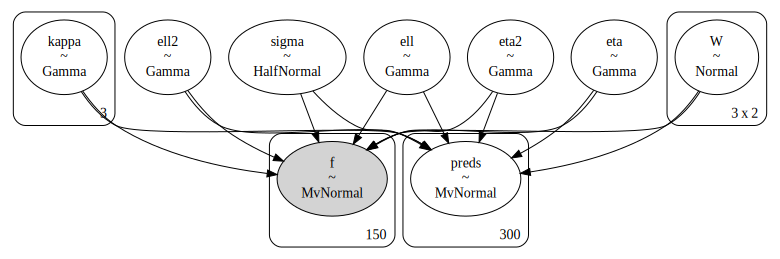

In [37]:
pm.model_to_graphviz(model)

In [38]:
Xnew.shape

(300, 2)

In [39]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 300)

#### Plot the GP prediction

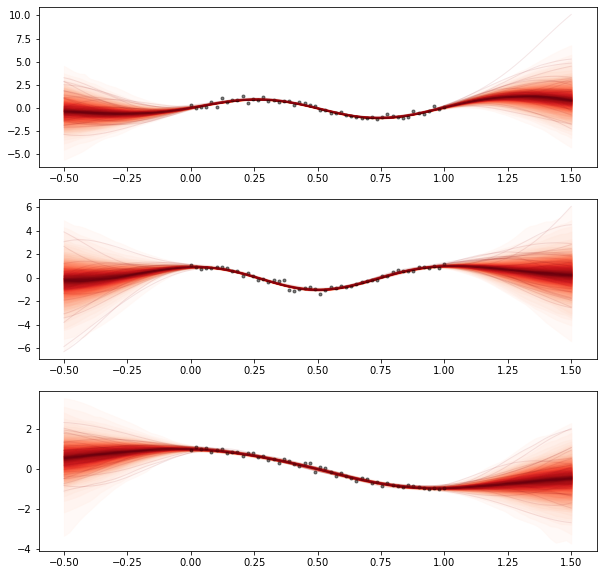

In [40]:
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [41]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",-0.023,1.845,-3.354,3.235,0.102,0.099,324.0,303.0,NaN
"W[0, 1]",0.072,2.035,-4.029,3.421,0.105,0.098,386.0,320.0,NaN
"W[1, 0]",-0.026,2.003,-3.490,4.118,0.115,0.085,306.0,272.0,NaN
"W[1, 1]",0.122,2.012,-3.543,3.761,0.126,0.089,254.0,326.0,NaN
"W[2, 0]",-0.021,0.952,-1.726,1.855,0.038,0.047,615.0,408.0,NaN
"W[2, 1]",0.041,0.932,-1.730,1.894,0.036,0.051,629.0,344.0,NaN
ell,0.355,0.047,0.258,0.429,0.002,0.002,406.0,408.0,NaN
eta,0.882,0.372,0.296,1.581,0.021,0.015,337.0,240.0,NaN
ell2,4.889,3.093,0.754,9.943,0.129,0.095,452.0,285.0,NaN
eta2,0.936,0.705,0.108,2.192,0.034,0.024,438.0,378.0,NaN


In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Sep 07 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

matplotlib: 3.5.2
pymc      : 4.1.5
numpy     : 1.22.4
arviz     : 0.12.1

Watermark: 2.3.0

